In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import time

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# testing some code

In [2]:
name = '0a148697c.jpg'
labels_file =  "../data/labels/boxes_v2.csv"
path = '../data/'
pimg = 'train_sample/'
pgt = 'train_maps/'

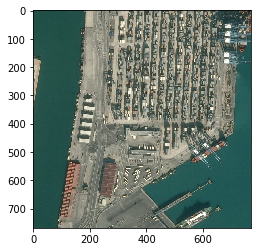

In [3]:
img = mpimg.imread(path + pimg + name)
plt.imshow(img)
plt.show()

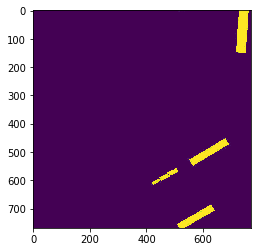

In [4]:
gt = mpimg.imread(path + pgt + "gt_" + name)
plt.imshow(gt)
plt.show()

In [5]:
y_raw = pd.read_csv(labels_file)
y_raw.head(2)

,ImageId,width,height,lt_x,lt_y,rb_x,rb_y
0,00003e153.jpg,0,0,0,0,0,0
1,0001124c7.jpg,0,0,0,0,0,0


In [6]:
y_raw[y_raw.ImageId==name]

,ImageId,width,height,lt_x,lt_y,rb_x,rb_y
9180,0a148697c.jpg,26,38,557,473,583,511
9181,0a148697c.jpg,150,44,1,715,151,759
9182,0a148697c.jpg,26,36,575,445,601,481
9183,0a148697c.jpg,82,132,685,507,767,639
9184,0a148697c.jpg,23,30,593,418,616,448
9185,0a148697c.jpg,97,140,451,550,548,690


In [7]:
def get_y_data(y_raw, filename):
    '''
    Converts a filename into an array, with one channel for each boat in the image
    :param filename: filename string
    :return: np array of size [h, w, n_boats_in_this_image]
    '''
    ground_truths = y_raw[y_raw.ImageId == filename]
    array_of_coords = np.array(ground_truths[['lt_x', 'lt_y', 'rb_x', 'rb_y']])
    # array_of_coords is of shape [n_boxes, 4]

    n_boxes = array_of_coords.shape[0]
    y_map = np.zeros((768, 768, n_boxes))

    for box_idx in range(n_boxes):
        # Loop over amount of boats per image ~ of order 10.
        box = array_of_coords[box_idx, :]
        # TODO: check that im using dimensions correctly here and agrees with static file
        y_map[box[0]:box[2], box[1]:box[3], box_idx] = 1

    return y_map

In [8]:
y_map = get_y_data(y_raw,name)
y_map.shape

(768, 768, 6)

In [9]:
y_map = tf.convert_to_tensor(y_map)
y_map = tf.reshape(y_map, [1, 768, 768, 6])

# testing anchor code

In [10]:
import cv2 as cv

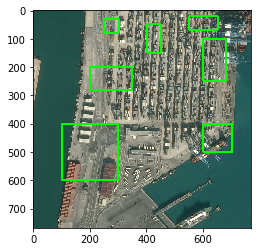

In [11]:
gt = np.copy(img)
gt = cv.rectangle(gt, (400,50), (450,150), (0,255,0), 5) #(51,101)
gt = cv.rectangle(gt, (550,20), (650,70), (0,255,0), 5) #(101,51)
gt = cv.rectangle(gt, (250,30), (301,81), (0,255,0), 5) #(51,51)
gt = cv.rectangle(gt, (600,400), (700,500), (0,255,0), 5) #(101,101)
gt = cv.rectangle(gt, (200,200), (350,280), (0,255,0), 5) #(151,81)
gt = cv.rectangle(gt, (600,100), (680,250), (0,255,0), 5) #(81, 151)
gt = cv.rectangle(gt, (100,400), (300,600), (0,255,0), 5) # (201,201)
plt.imshow(gt)

In [ ]:
(51,101),(101,51),(51,51), (151,81), 81, 151), (201,201)

In [19]:
# original code
for i, anchor_shape in enumerate(anchor_shapes):
    # Loop over number of anchors ~ of order 9
    # The y_map is of shape [batch_size, h, w, max_n_boats]
    # The kenerl we convolve with is of shape [anchor_shape[0], anchor_shape[1], max_n_boats, max_n_boats]
    # where every entry is 0 except for [:,:, i, i] for all i.
    # (I think) this is equivalent to running a seperate "all ones" [anchor_shape[0], anchor_shape[1], 1]
    # kernel over each of the max_n_boats inputs.
    # TODO: double (triple, quadruple...) check above logic.

    n_box = tf.shape(self.y_map)[-1]
    anchor = tf.zeros((anchor_shape[0], anchor_shape[1], n_box, n_box))
    diagonal = tf.ones((anchor_shape[0], anchor_shape[1], n_box))
    anchor_area = anchor_shape[0]*anchor_shape[1]

    # Assigns ones to anchor[:,:,i,i] (https://www.tensorflow.org/api_docs/python/tf/linalg/set_diag)
    anchor = tf.linalg.set_diag(anchor, diagonal)

    # Calculates the intersection of anchor with each gt map in y_map simulatenously (as above)
    intersection = tf.nn.conv2d(self.y_map, anchor, strides=[1, 1, 1, 1], padding='SAME')

    # union is the area of the map (per map layer, and per batch entry) + the anchor area (in 2d)
    # TODO: check that minusing intersection does so entry wise.
    union = tf.reduce_sum(self.y_map, [1, 2], keepdims=True) + anchor_area - intersection
    ious = tf.divide(intersection, union)
    max_iou_over_ground_truth = tf.reduce_max(ious, -1)

    tf.summary.scalar(name='max_gt_iou_' + str(i),
                      tensor=tf.reduce_max(max_iou_over_ground_truth))

    summarise_map(name='iou_' + str(i), tensor=max_iou_over_ground_truth)

    labels = tf.greater(max_iou_over_ground_truth, self.config.iou_threshold)
    labels = tf.cast(labels, tf.float32)
    # TODO: test this somehow

    y_class.append(labels)

NameError: name 'self' is not defined

TESTING

In [12]:
anchor_shapes = [(51,101),(101,51),(51,51), (151,81), (81, 151), (201,201)]

In [13]:
i = 0
list_IoU = []
for i, anchor_shape in enumerate(anchor_shapes):
    n_box = tf.shape(y_map)[-1]
    anchor = tf.zeros((anchor_shape[0], anchor_shape[1], n_box, n_box),dtype=tf.float64)
    diagonal = tf.ones((anchor_shape[0], anchor_shape[1], n_box), dtype=tf.float64)
    anchor_area = anchor_shape[0]*anchor_shape[1]

    # Assigns ones to anchor[:,:,i,i] (https://www.tensorflow.org/api_docs/python/tf/linalg/set_diag)
    anchor = tf.linalg.set_diag(anchor, diagonal)

    # Calculates the intersection of anchor with each gt map in y_map simulatenously (as above)
    intersection = tf.nn.conv2d(y_map, anchor, strides=[1, 1, 1, 1], padding='SAME')

    # union is the area of the map (per map layer, and per batch entry) + the anchor area (in 2d)
    # TODO: check that minusing intersection does so entry wise.
    union = tf.reduce_sum(y_map, [1, 2], keepdims=True) + anchor_area - intersection
    ious = tf.divide(intersection, union)
    max_iou_over_ground_truth = tf.reduce_max(ious, -1)
    list_IoU.append(max_iou_over_ground_truth)
    
IoU_matrix = tf.stack(list_IoU, axis=-1)

### let's look at the intersection:

In [40]:
with tf.Session() as sess:
    array = intersection.eval(session=sess)

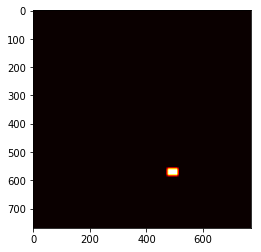

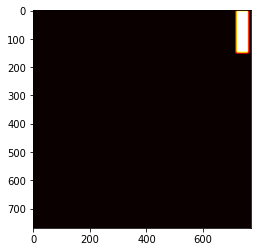

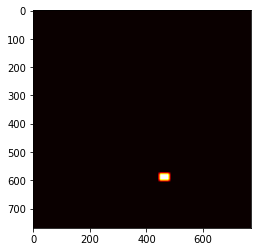

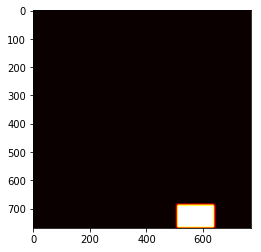

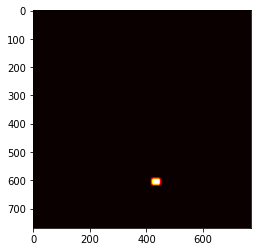

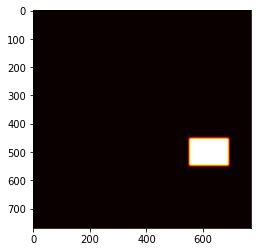

In [45]:
for i in range(6):
    plt.imshow(array[0,:,:,i], cmap='hot', interpolation='nearest')
    plt.show()

### let's look at the union

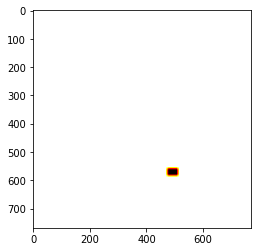

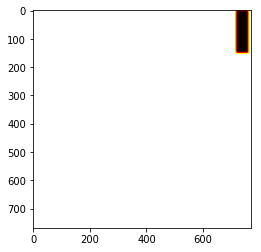

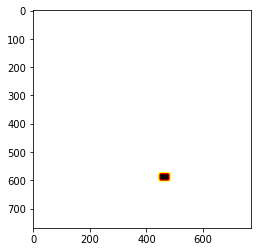

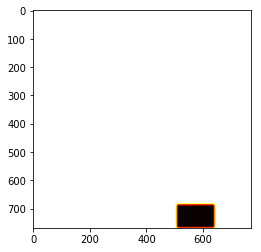

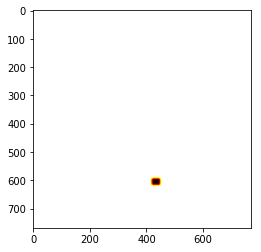

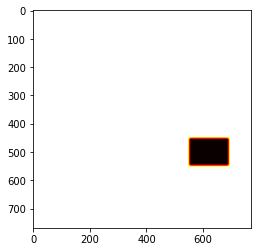

In [72]:
with tf.Session() as sess:
    array = union.eval(session=sess)
for i in range(6):
    plt.imshow(array[0,:,:,i], cmap='hot', interpolation='nearest')
    plt.show()

### Let's look at IOUs

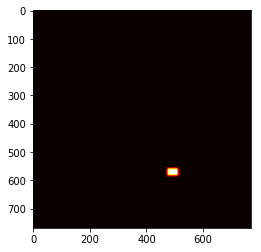

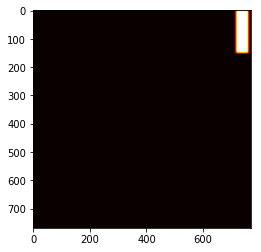

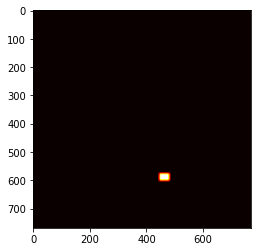

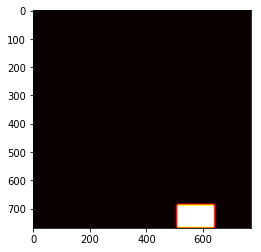

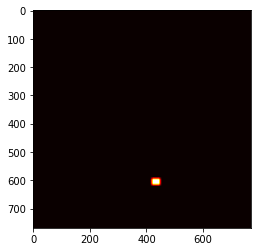

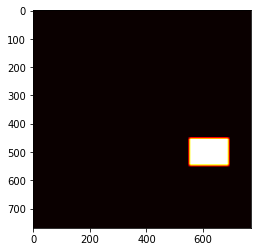

In [73]:
with tf.Session() as sess:
    array = ious.eval(session=sess)
for i in range(6):
    plt.imshow(array[0,:,:,i], cmap='hot', interpolation='nearest')
    plt.show()

In [ ]:
### here we calculate the max IOU

In [14]:
tfeval = IoU_matrix
with tf.Session() as sess:
    startTime = time.time()
    array = tfeval.eval(session=sess)
    print("Time: {}".format(time.time() - startTime))

Time: 1529.4116678237915


0.3361302938046088


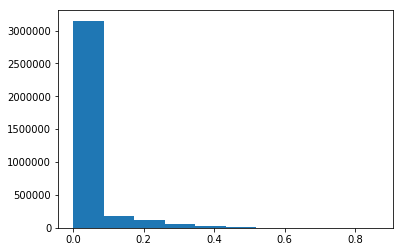

In [39]:
max_iou = np.copy(array)
print(np.max(max_iou[:,:,:,5]))
plt.hist(max_iou.flatten())
plt.show()

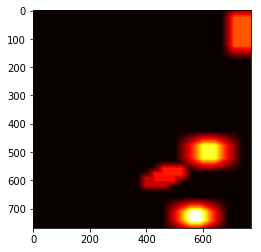

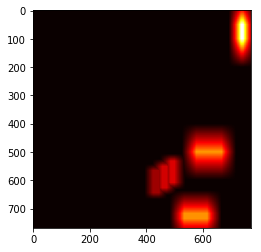

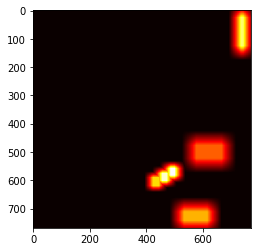

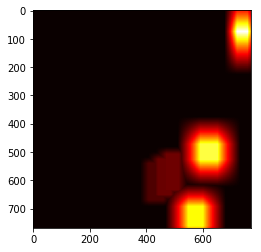

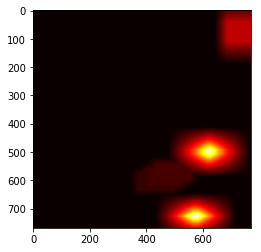

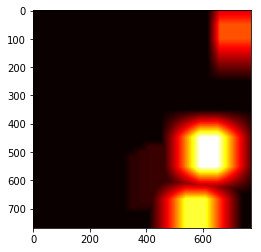

In [45]:
for i in range(6):
    plt.imshow(array[0,:,:,i], cmap='hot', interpolation='nearest')
    plt.show()

0.8069597930872325
0.0


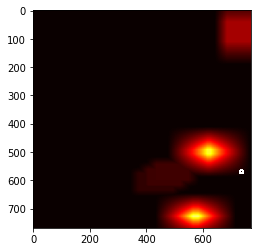

In [89]:
i, j =729, 564
gt = np.copy(array[0,:,:,4])
print(gt[i,j])
print(gt[100,100])
gt = cv.rectangle(gt, (i,j), (i+10,j+10), (1,1,1), 5)
plt.imshow(gt, cmap='hot', interpolation='nearest')
plt.show()

In [63]:
print(array[:,:,:,4].max())

0.8648386314001456


In [67]:
print(array[0,729, 564,4].max())

0.8069597930872325


array should have dimensions [768,768,k], given the centre pixel (x,y) then 
- the top left corner is: [(x - (w-1)/2),(y - (h-1)/2)]
- the bottom right corner is: [(x + (w-1)/2),(y + (h-1)/2)]

722 563
722 564
722 565
722 566
722 567
722 568
722 569
722 570
722 571
722 572
722 573
722 574
722 575
722 576
722 577
722 578
722 579
722 580
722 581
722 582
723 561
723 562
723 563
723 564
723 565
723 566
723 567
723 568
723 569
723 570
723 571
723 572
723 573
723 574
723 575
723 576
723 577
723 578
723 579
723 580
723 581
723 582
723 583
723 584
724 560
724 561
724 562
724 563
724 564
724 565
724 566
724 567
724 568
724 569
724 570
724 571
724 572
724 573
724 574
724 575
724 576
724 577
724 578
724 579
724 580
724 581
724 582
724 583
724 584
724 585
725 558
725 559
725 560
725 561
725 562
725 563
725 564
725 565
725 566
725 567
725 568
725 569
725 570
725 571
725 572
725 573
725 574
725 575
725 576
725 577
725 578
725 579
725 580
725 581
725 582
725 583
725 584
725 585
725 586
725 587
726 558
726 559
726 560
726 561
726 562
726 563
726 564
726 565
726 566
726 567
726 568
726 569
726 570
726 571
726 572
726 573
726 574
726 575
726 576
726 577
726 578
726 579
726 580
726 581
726 582


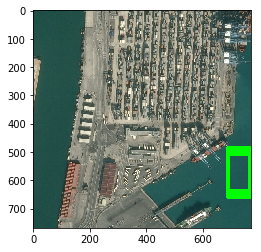

In [66]:
gt = np.copy(img)
a = np.asarray([[51,101],[101,51],[51,51], [151,81], [81, 151], [201,201]])
for i in range(array.shape[1]):
    for j in range(array.shape[2]):
        for k in range(array.shape[3]):
            if array[0,i,j,k] > 0.8:
                print(i,j)
                gt = cv.rectangle(gt,(i - int((a[k,0]-1)/2),j-int((a[k,1]-1)/2)), (i+int((a[k,0]-1)/2),j+int((a[k,1]-1)/2)), (0,255,0), 5)
plt.imshow(gt)
plt.show()

In [87]:
max_iou.shape

(1, 768, 768)

In [80]:
labels = tf.greater(max_iou_over_ground_truth, 0.5)
tfeval = labels
with tf.Session() as sess:
    array = tfeval.eval(session=sess)

In [81]:
array[0,445:460,600]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

### for the regression, we need to know which boat we are looking at

In [88]:
tf.argmax(ious, axis=[1,2])

ValueError: Shape must be rank 0 but is rank 1 for 'ArgMax' (op: 'ArgMax') with input shapes: [1,768,768,6], [2].

In [15]:
# TESTER
def tester(test):
    # Intialize the Session
    sess = tf.Session()
    # Print the result
    print(sess.run(test))
    # Close the session
    sess.close()